In [96]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules

In [4]:
#prepping the data
path = 'alzheimers_disease_data.csv'
data = pd.read_csv(path)
data.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [5]:
# cleaning duplicates in data set
data.drop_duplicates(subset='PatientID', inplace=True)
data.drop(columns='PatientID', axis=1, inplace=True)
print(data.columns)

Index(['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking',
       'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
       'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes',
       'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP',
       'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
       'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
       'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
       'Forgetfulness', 'Diagnosis', 'DoctorInCharge'],
      dtype='object')


In [88]:
print("Column containing missing values:")
print(data.columns[data.isnull().any()].tolist())

print("\n\nNull values in data set:")
print(data.isnull().sum())

df = pd.DataFrame(data)

df= df.drop(columns='DoctorInCharge')

Column containing missing values:
[]


Null values in data set:
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
Diffic

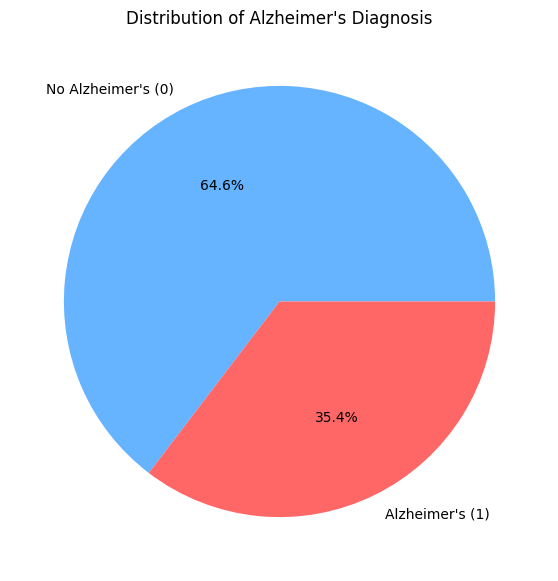

In [102]:
# Get the count of 0's and 1's in the Diagnosis column
diagnosis_counts = df['Diagnosis'].value_counts()

# Create the pie chart
plt.figure(figsize=(7, 7))  # Set the figure size
plt.pie(diagnosis_counts, labels=["No Alzheimer's (0)", "Alzheimer's (1)"], autopct='%1.1f%%', colors=['#66b3ff', '#ff6666'])

# Add a title
plt.title('Distribution of Alzheimer\'s Diagnosis')

# Show the plot
plt.show()

In [ ]:
# Medical History Columns

medical_history_columns = [
    'FamilyHistoryAlzheimers',
    'CardiovascularDisease',
    'Diabetes',
    'Depression',
    'HeadInjury',
    'Hypertension',
    'Diagnosis'
]


mh_columns = df[medical_history_columns].copy()

# saving this to a new excel file
output_file = "csv/medical_history_columns.csv"
mh_columns.to_csv(output_file, index=False)

# print(mh_columns)


In [84]:
# Medical History Diagnosed
mh_yes = mh_columns[mh_columns['Diagnosis'] == 1]
mh_yes = mh_yes.astype(bool)

# print(mh_no)
mh_yes = mh_yes.drop(columns=['Diagnosis'])
mh_yes.head()

# Apply apriori
mh_yes_frequent_itemsets = apriori(mh_yes, min_support=0.01, use_colnames=True)


# Generate rules
mh_yes_rules = association_rules(mh_yes_frequent_itemsets, metric='lift', min_threshold=1.05, num_itemsets=len(mh_yes_frequent_itemsets))
mh_yes_rules = mh_yes_rules.sort_values(by='lift', ascending=False)
mh_yes_rules = mh_yes_rules.drop(columns=['conviction','representativity', 'zhangs_metric','jaccard','certainty','kulczynski'])

# print(mh_yes_frequent_itemsets)
print(mh_yes_rules)

output_file_assoc_rules = "csv/medical_history_YesDiagnosed.csv"
mh_yes_rules.to_csv(output_file_assoc_rules, index=False)


                  antecedents                consequents  antecedent support  \
7                (Depression)                 (Diabetes)            0.197368   
6                  (Diabetes)               (Depression)            0.135526   
3     (CardiovascularDisease)                 (Diabetes)            0.159211   
2                  (Diabetes)    (CardiovascularDisease)            0.135526   
1   (FamilyHistoryAlzheimers)    (CardiovascularDisease)            0.232895   
0     (CardiovascularDisease)  (FamilyHistoryAlzheimers)            0.159211   
11             (Hypertension)                 (Diabetes)            0.165789   
10                 (Diabetes)             (Hypertension)            0.135526   
12               (Depression)             (Hypertension)            0.197368   
13             (Hypertension)               (Depression)            0.165789   
9                (HeadInjury)                 (Diabetes)            0.084211   
8                  (Diabetes)           

In [73]:
# Symptoms 
symptom_and_assessment_columns = [
  'Confusion',
  'Disorientation',
  'PersonalityChanges',
  'DifficultyCompletingTasks',
  'Forgetfulness',
  'Diagnosis'
]

s_columns = df[symptom_and_assessment_columns].copy()

# saving this to a new excel file
output_file = "csv/symptom_and_assessment_columns.csv"
s_columns.to_csv(output_file, index=False)

# print(s_columns)


In [ ]:
# Symtoms Diagnosed

s_yes = s_columns[s_columns['Diagnosis'] == 1]
s_yes = s_yes.astype(bool)

s_yes = s_yes.drop(columns=['Diagnosis'])

s_yes.head()

# Apply apriori
s_yes_frequent_itemsets = apriori(s_yes, min_support=0.01, use_colnames=True)

# Generate rules
s_yes_rules = association_rules(s_yes_frequent_itemsets, metric='lift', min_threshold=1.05, num_itemsets=len(s_yes_frequent_itemsets))
s_yes_rules = s_yes_rules.sort_values(by='lift', ascending=False)
s_yes_rules = s_yes_rules.drop(columns=['conviction','representativity', 'zhangs_metric','jaccard','certainty','kulczynski'])

# print(s_yes_frequent_itemsets)
print(s_yes_rules)

output_file_assoc_rules = "csv/symptom_YesDiagnosed.csv"
s_yes_rules.to_csv(output_file_assoc_rules, index=False)

                               antecedents  \
7                              (Confusion)   
2          (Disorientation, Forgetfulness)   
4               (Forgetfulness, Confusion)   
5                         (Disorientation)   
6                          (Forgetfulness)   
3              (Disorientation, Confusion)   
9          (PersonalityChanges, Diagnosis)   
10             (DifficultyCompletingTasks)   
0              (DifficultyCompletingTasks)   
1                     (PersonalityChanges)   
8   (DifficultyCompletingTasks, Diagnosis)   
11                    (PersonalityChanges)   

                               consequents  antecedent support  \
7          (Disorientation, Forgetfulness)            0.205212   
2                              (Confusion)            0.042345   
4                         (Disorientation)            0.063751   
5               (Forgetfulness, Confusion)            0.158213   
6              (Disorientation, Confusion)            0.301536   
3    

c:\Users\Acer\Desktop\Charlene_CollegeStuff\3.1\CSIT349_APPLIED AI\Data-Analysis-Finals\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [91]:
yesno_columns = [
  'Smoking',
  'FamilyHistoryAlzheimers',
  'CardiovascularDisease',
  'Diabetes',
  'Depression',
  'HeadInjury',
  'Hypertension',
  'MemoryComplaints',
  'BehavioralProblems',
  'Confusion',
  'Disorientation',
  'PersonalityChanges',
  'DifficultyCompletingTasks',
  'Forgetfulness',
  'Diagnosis'
]

yn_columns = df[yesno_columns].copy()

yn_columns = yn_columns.astype(bool)
nn = ((apriori(yn_columns, min_support=0.01, use_colnames=True)).sort_values(by='support', ascending=False))
nn = nn[nn['itemsets'].apply(lambda x: len(x) == 1)]
print(nn)

# saving this to a new excel file

output_file_assoc_rules = "csv/alzheimers_categorical_columns.csv"
yn_columns.to_csv(output_file_assoc_rules, index=False)

# print(yn_columns)


     support                     itemsets
14  0.353653                  (Diagnosis)
13  0.301536              (Forgetfulness)
0   0.288506                    (Smoking)
1   0.252210    (FamilyHistoryAlzheimers)
7   0.208004           (MemoryComplaints)
9   0.205212                  (Confusion)
4   0.200558                 (Depression)
12  0.158678  (DifficultyCompletingTasks)
10  0.158213             (Disorientation)
8   0.156817         (BehavioralProblems)
11  0.150768         (PersonalityChanges)
3   0.150768                   (Diabetes)
6   0.148906               (Hypertension)
2   0.144253      (CardiovascularDisease)
5   0.092601                 (HeadInjury)


In [94]:
# Categorical columns Diagnosed
yn_yes = yn_columns[yn_columns['Diagnosis'] == 1]
yn_yes = yn_yes.astype(bool)

yn_yes = yn_yes.drop(columns=['Diagnosis'])

yn_yes.head()

# Apply apriori

yn_yes_frequent_itemsets = apriori(yn_yes, min_support=0.01, use_colnames=True)

# Generate rules

yn_yes_rules = association_rules(yn_yes_frequent_itemsets, metric='lift', min_threshold=1.5, num_itemsets=len(yn_yes_frequent_itemsets))
yn_yes_rules = yn_yes_rules.sort_values(by='lift', ascending=False)
yn_yes_rules = yn_yes_rules[yn_yes_rules['confidence'] > 0.35]
yn_yes_rules = yn_yes_rules.drop(columns=['conviction','representativity', 'zhangs_metric','jaccard','certainty','kulczynski'])


# print(yn_yes_frequent_itemsets)
print(yn_yes_rules)

output_file_assoc_rules = "csv/alzheimers_categorical_YesDiagnosed.csv"

yn_yes_rules.to_csv(output_file_assoc_rules, index=False)


                                        antecedents  \
3                             (Depression, Smoking)   
40                            (Diabetes, Confusion)   
41              (Diabetes, FamilyHistoryAlzheimers)   
34          (Disorientation, CardiovascularDisease)   
52  (DifficultyCompletingTasks, PersonalityChanges)   
26               (Hypertension, PersonalityChanges)   
30      (BehavioralProblems, CardiovascularDisease)   
8             (CardiovascularDisease, Hypertension)   
72                            (Diabetes, Confusion)   
2               (Depression, CardiovascularDisease)   
46                        (Hypertension, Confusion)   
13                 (CardiovascularDisease, Smoking)   
12           (CardiovascularDisease, Forgetfulness)   

                  consequents  antecedent support  consequent support  \
3     (CardiovascularDisease)            0.044737            0.159211   
40  (FamilyHistoryAlzheimers)            0.025000            0.232895   
41        